In [76]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import LabelEncoder




In [70]:
# Képek betöltése és előfeldolgozása
def preprocess_image(img):
    # 1. Szürkeárnyalatossá alakítás
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Sobel éldetektálás
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobel_x, sobel_y)

    # 3. Morfológiai gradiens
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morph_gradient = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)

    # 4. Felüláteresztő szűrő
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)
    high_pass = cv2.subtract(gray, blurred)

    # 5. Top-hat transzformáció
    top_hat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

    # 6. Összesített jellemzők (konkatenáció)
    combined_features = np.hstack([
        sobel.flatten(),
        morph_gradient.flatten(),
        high_pass.flatten(),
        top_hat.flatten()
    ])
    
    return combined_features

In [71]:
img_dir = '/Users/majer/Desktop/Brain_CT/agyikepek_3_osztaly/kepek'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img_resized = cv2.resize(img, (128, 128))
            img_normalized = img_resized / 255.0
            features = preprocess_image(img_resized)
            images.append(features)
    return images

images = []
images = load_images_from_folder(img_dir)



In [72]:
labels = os.listdir(img_dir)
print(len(images))
print(len(labels))
print(labels)
for i in range(len(labels)):
    tmp = labels[i].split('.')
    labels[i] = tmp[0][-1]

print(labels)


3064
3064
['1000_3.png', '1001_3.png', '1002_3.png', '1003_3.png', '1004_3.png', '1005_3.png', '1006_3.png', '1007_3.png', '1008_3.png', '1009_3.png', '100_1.png', '1010_3.png', '1011_3.png', '1012_3.png', '1013_3.png', '1014_3.png', '1015_3.png', '1016_3.png', '1017_3.png', '1018_3.png', '1019_3.png', '101_1.png', '1020_3.png', '1021_3.png', '1022_3.png', '1023_3.png', '1024_3.png', '1025_3.png', '1026_3.png', '1027_3.png', '1028_3.png', '1029_3.png', '102_1.png', '1030_3.png', '1031_3.png', '1032_3.png', '1033_3.png', '1034_3.png', '1035_3.png', '1036_3.png', '1037_3.png', '1038_3.png', '1039_3.png', '103_1.png', '1040_3.png', '1041_3.png', '1042_3.png', '1043_3.png', '1044_3.png', '1045_3.png', '1046_3.png', '1047_3.png', '1048_3.png', '1049_3.png', '104_1.png', '1050_3.png', '1051_3.png', '1052_3.png', '1053_3.png', '1054_3.png', '1055_3.png', '1056_3.png', '1057_3.png', '1058_3.png', '1059_3.png', '105_1.png', '1060_3.png', '1061_3.png', '1062_3.png', '1063_3.png', '1064_3.png', '

In [ ]:
#csak flatten nelkul mukodik
fig, axes = plt.subplots(5,5, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(images[i])

In [73]:
df = pd.DataFrame()
df['label']=labels
df['image']=images
print(df.head())
print(df['label'].value_counts())

  label                                              image
0     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
label
2    1426
3     930
1     708
Name: count, dtype: int64


In [74]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


Validációs pontosság: 0.9282218597063622
Validációs veszteség (log loss): 0.25743722067282077


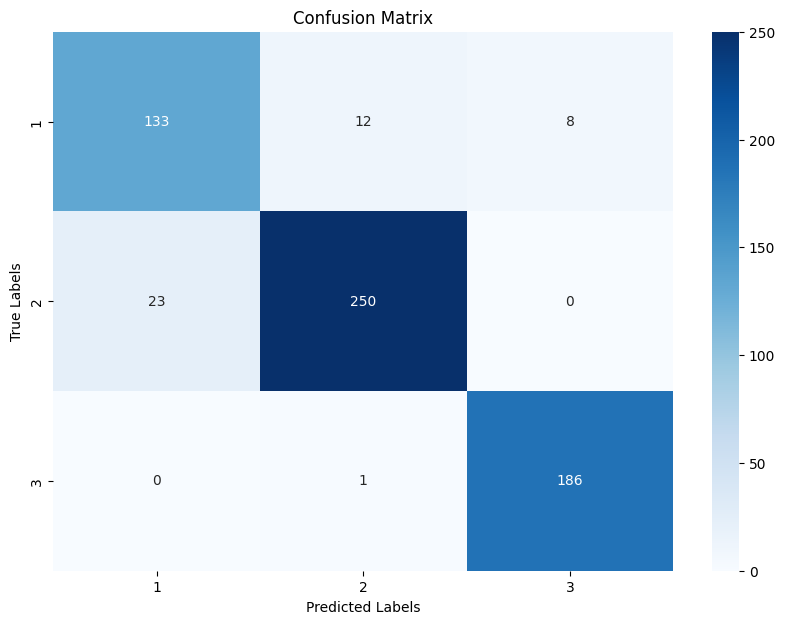

Osztályozási jelentés:
              precision    recall  f1-score   support

           1       0.85      0.87      0.86       153
           2       0.95      0.92      0.93       273
           3       0.96      0.99      0.98       187

    accuracy                           0.93       613
   macro avg       0.92      0.93      0.92       613
weighted avg       0.93      0.93      0.93       613



In [77]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

acc= accuracy_score(y_test,y_pred)

validation_accuracy = accuracy_score(y_test, y_pred)
print("Validációs pontosság:", validation_accuracy)

validation_loss = log_loss(y_test, y_pred_proba)
print("Validációs veszteség (log loss):", validation_loss)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("Osztályozási jelentés:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))